# Classification Analysis of Suicide Rates

The classification and prediction of groups at high risks of suicide is important for preventing suicides. Thus, this analysis aims to investigate whether several features such as age, sex, population, etc. have classification power for identifying high risk groups.

I will be using the "Suicides Rates Overview 1985 to 2016" dataset from Kaggle to perform exploratory data analysis and classification analysis in order to find the best classifier.

In [186]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### Loading the Dataset

In [136]:
url = "https://raw.githubusercontent.com/uplotnik/Data607/master/Suicide.csv"
data = pd.read_csv(url)

# Changing the names of the columns
data.columns = ["country", "year", "sex", "age", "suicides_no", "population", "suicides_per_100k_pop", "country-year", "HDI_for_year", "gdp_for_year", "gdp_per_capita", "generation"]

data.head()

,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,country-year,HDI_for_year,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,nan,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,nan,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,nan,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,nan,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,nan,"2,156,624,900",796,Boomers


In [137]:
data.tail()

,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,country-year,HDI_for_year,gdp_for_year,gdp_per_capita,generation
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.68,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.68,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.68,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.68,"63,067,077,179",2309,Generation Z
27819,Uzbekistan,2014,female,55-74 years,21,1438935,1.46,Uzbekistan2014,0.68,"63,067,077,179",2309,Boomers


## Data Wrangling and Exploratory Data Analysis

In [138]:
# Creating a binary class 

# If suicides_per_100k_pop > mean(suicides_per_100k_pop), then high risk
# Else, low risk

mean = data["suicides_per_100k_pop"].mean()
data['risk'] = (data["suicides_per_100k_pop"] >= mean) *1
data.head()

,country,year,sex,age,suicides_no,population,suicides_per_100k_pop,country-year,HDI_for_year,gdp_for_year,gdp_per_capita,generation,risk
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,nan,"2,156,624,900",796,Generation X,0
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,nan,"2,156,624,900",796,Silent,0
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,nan,"2,156,624,900",796,Generation X,0
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,nan,"2,156,624,900",796,G.I. Generation,0
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,nan,"2,156,624,900",796,Boomers,0


In [139]:
# Checking for missing values
data.isnull().sum()

country                      0
year                         0
sex                          0
age                          0
suicides_no                  0
population                   0
suicides_per_100k_pop        0
country-year                 0
HDI_for_year             19456
gdp_for_year                 0
gdp_per_capita               0
generation                   0
risk                         0
dtype: int64

In [140]:
# cleaning the data

# Removing commas from the "gdp_for_year" column
data['gdp_for_year'] = data['gdp_for_year'].str.replace(',', '')


# Dropping HDI_for_year because of a lot of missing values
data = data.drop(["HDI_for_year"], axis = 1)


In [141]:
# Checking if there is any missing values again
data.isnull().any()

country                  False
year                     False
sex                      False
age                      False
suicides_no              False
population               False
suicides_per_100k_pop    False
country-year             False
gdp_for_year             False
gdp_per_capita           False
generation               False
risk                     False
dtype: bool

In [142]:
# Information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                27820 non-null  object 
 1   year                   27820 non-null  int64  
 2   sex                    27820 non-null  object 
 3   age                    27820 non-null  object 
 4   suicides_no            27820 non-null  int64  
 5   population             27820 non-null  int64  
 6   suicides_per_100k_pop  27820 non-null  float64
 7   country-year           27820 non-null  object 
 8   gdp_for_year           27820 non-null  object 
 9   gdp_per_capita         27820 non-null  int64  
 10  generation             27820 non-null  object 
 11  risk                   27820 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 2.5+ MB


In [143]:
# Changing the data type of the "gdp_for_year" column

data["gdp_for_year"] = data["gdp_for_year"].astype(float)

In [144]:
# Summary of statistics for numerical variables

# 2 decimal places
pd.options.display.float_format = "{:.2f}".format
data.describe()

,year,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita,risk
count,27820.00,27820.00,27820.00,27820.00,27820.00,27820.00,27820.00
mean,2001.26,242.57,1844793.62,12.82,445580969025.73,16866.46,0.31
std,8.47,902.05,3911779.44,18.96,1453609985940.92,18887.58,0.46
min,1985.00,0.00,278.00,0.00,46919625.00,251.00,0.00
25%,1995.00,3.00,97498.50,0.92,8985352832.00,3447.00,0.00
50%,2002.00,25.00,430150.00,5.99,48114688201.00,9372.00,0.00
75%,2008.00,131.00,1486143.25,16.62,260202429150.00,24874.00,1.00
max,2016.00,22338.00,43805214.00,224.97,18120714000000.00,126352.00,1.00


In [145]:
# Number of unique values 
data.nunique()

country                    101
year                        32
sex                          2
age                          6
suicides_no               2084
population               25564
suicides_per_100k_pop     5298
country-year              2321
gdp_for_year              2321
gdp_per_capita            2233
generation                   6
risk                         2
dtype: int64

In [146]:
# Unique values for relevant columns
cols = data[["country", "year", "sex", "age", "generation", "risk"]]

for column in list(cols):
    print(f"\033[1m  {column} unique values: \033[0m")
    print("")
    print(data[column].unique())
    print("")

  country unique values: 

['Albania' 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Barbados' 'Belarus' 'Belgium'
 'Belize' 'Bosnia and Herzegovina' 'Brazil' 'Bulgaria' 'Cabo Verde'
 'Canada' 'Chile' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus'
 'Czech Republic' 'Denmark' 'Dominica' 'Ecuador' 'El Salvador' 'Estonia'
 'Fiji' 'Finland' 'France' 'Georgia' 'Germany' 'Greece' 'Grenada'
 'Guatemala' 'Guyana' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Italy'
 'Jamaica' 'Japan' 'Kazakhstan' 'Kiribati' 'Kuwait' 'Kyrgyzstan' 'Latvia'
 'Lithuania' 'Luxembourg' 'Macau' 'Maldives' 'Malta' 'Mauritius' 'Mexico'
 'Mongolia' 'Montenegro' 'Netherlands' 'New Zealand' 'Nicaragua' 'Norway'
 'Oman' 'Panama' 'Paraguay' 'Philippines' 'Poland' 'Portugal'
 'Puerto Rico' 'Qatar' 'Republic of Korea' 'Romania' 'Russian Federation'
 'Saint Kitts and Nevis' 'Saint Lucia' 'Saint Vincent and Grenadines'
 'San Marino' 'Serbia' 'Seychelles' 'Singapore' 'Sl

### Correlation Matrix and Heatmap 

In [147]:
# Correlation matrix for numerical variables
continuous = data.drop(["risk"], axis = 1)
corr = continuous.corr()
corr

,year,suicides_no,population,suicides_per_100k_pop,gdp_for_year,gdp_per_capita
year,1.00,-0.00,0.01,-0.04,0.09,0.34
suicides_no,-0.00,1.00,0.62,0.31,0.43,0.06
population,0.01,0.62,1.00,0.01,0.71,0.08
suicides_per_100k_pop,-0.04,0.31,0.01,1.00,0.03,0.00
gdp_for_year,0.09,0.43,0.71,0.03,1.00,0.30
gdp_per_capita,0.34,0.06,0.08,0.00,0.30,1.00


Text(0.06, -0.16, 'Fig. 1. Correlation heatmap')

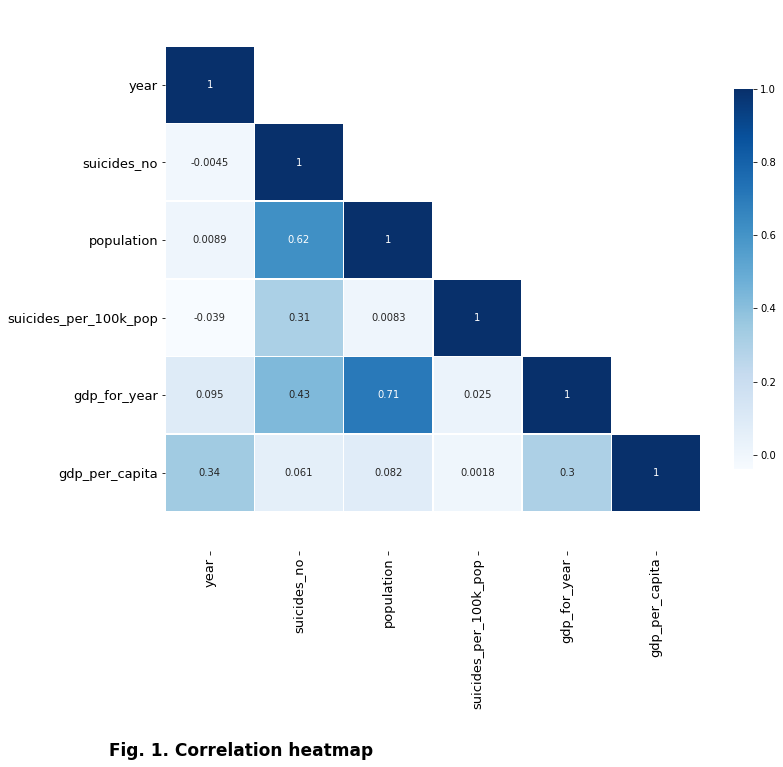

In [151]:
# Correlation heatmap for numerical variables

# Lower triangle
corr_lower = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))

fig, ax = plt.subplots(figsize = (12,10))

ax = sns.heatmap(corr_lower, cmap = "Blues",annot = True, 
                 linewidths = 0.5, cbar_kws={"shrink": .7})

ax.tick_params(axis = "both", labelsize = 13)

# Fixing a bug
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fig.text(0.06,-0.16,"Fig. 1. Correlation heatmap", fontsize = 17, fontweight = "bold")


### Visualization of the Features

#### Total Suicides and Year

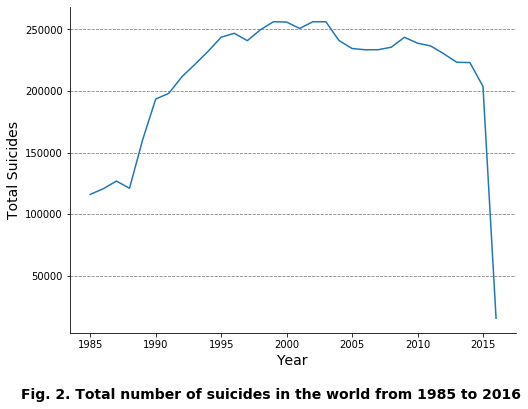

In [153]:
yearly_data = data.groupby("year").sum()

# Convert index into a column
yearly_data.reset_index(level = 0, inplace = True)

# Plotting
plt.rcParams["figure.figsize"] = [8, 6]
yearly_suicide_graph = yearly_data.plot(kind = "line", x = "year", y = "suicides_no")

# Setting the axis and title labels
yearly_suicide_graph.set_xlabel("Year", size = 14)
yearly_suicide_graph.set_ylabel("Total Suicides", size = 14)
yearly_suicide_graph.set_title("Fig. 2. Total number of suicides in the world from 1985 to 2016"
                               , x = 0.45, y = -0.22, 
                               size = 14, fontweight = "bold")

# Removing the top and right lines of the graph
yearly_suicide_graph.spines["right"].set_visible(False)
yearly_suicide_graph.spines["top"].set_visible(False)

# Removing the legend
yearly_suicide_graph.get_legend().remove()

# horizontal gridlines
yearly_suicide_graph.set_axisbelow(True)
yearly_suicide_graph.yaxis.grid(color = "gray", linestyle = "dashed")


#### Total Suicides and Year by Gender

In [260]:
# Checking to see if the number of females and males are balanced

print("Number of females and males:")
count1 = data['sex'].value_counts()
count1

Number of females and males:


male      13910
female    13910
Name: sex, dtype: int64

Therefore, the number of men and women is equal.

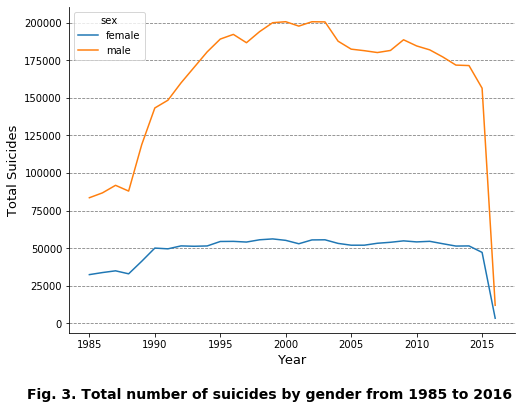

In [155]:
gender_data = data.groupby(["year", "sex"]).sum()
gender_table = gender_data.pivot_table(index = "year", columns = "sex", 
                        values = "suicides_no", aggfunc = "sum")
# Plotting
plt.rcParams["figure.figsize"] = [8, 6]
gender_graph = gender_table.plot()

gender_graph.spines["right"].set_visible(False)
gender_graph.spines["top"].set_visible(False)

plt.xlabel("Year", size = 13)
plt.ylabel("Total Suicides", size = 13)
plt.title("Fig. 3. Total number of suicides by gender from 1985 to 2016", 
          x = 0.45, y = -0.22,
          size = 14, fontweight = "bold")

gender_graph.set_axisbelow(True)
gender_graph.yaxis.grid(color = "gray", linestyle = "dashed")


#### Total Suicides and Year by Age

In [267]:
# Checking to see if the age groups are balanced in terms of number of observations

print("Number of observations for each age band:")
count = data['age'].value_counts()
count

Number of observations for each age band:


35-54 years    4642
55-74 years    4642
25-34 years    4642
75+ years      4642
15-24 years    4642
5-14 years     4610
Name: age, dtype: int64

Therefore, the number of observations is roughly equal for all age bands.

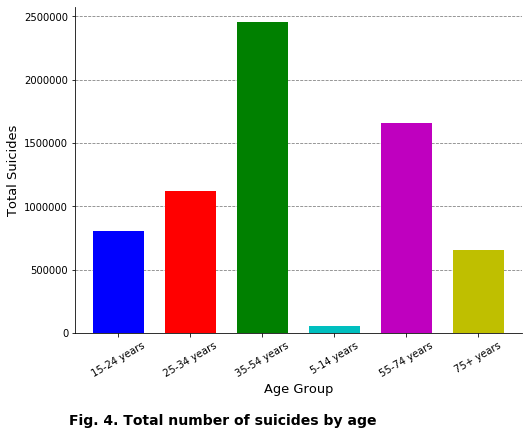

In [156]:
age_table = data.pivot_table('suicides_no', index='age', aggfunc='sum')
age_table.reset_index(level = 0, inplace = True)

# Plotting
# Colors of the bars
colors = ["b", "r", "g", "c", "m", "y"]
age_graph = age_table.plot(x = "age", y = "suicides_no", kind = "bar", 
                           width = 0.7, color = colors)

plt.xlabel("Age Group", size = 13)
plt.ylabel("Total Suicides", size = 13)
plt.title("Fig. 4. Total number of suicides by age", 
          x = 0.33, y = -0.3,
          size = 14, fontweight = "bold")
plt.xticks(rotation = 30)

age_graph.spines["right"].set_visible(False)
age_graph.spines["top"].set_visible(False)

# Removing the legend
age_graph.get_legend().remove()

age_graph.set_axisbelow(True)
age_graph.yaxis.grid(color = "gray", linestyle = "dashed")

#### Total Suicides and Year by Gender and Age

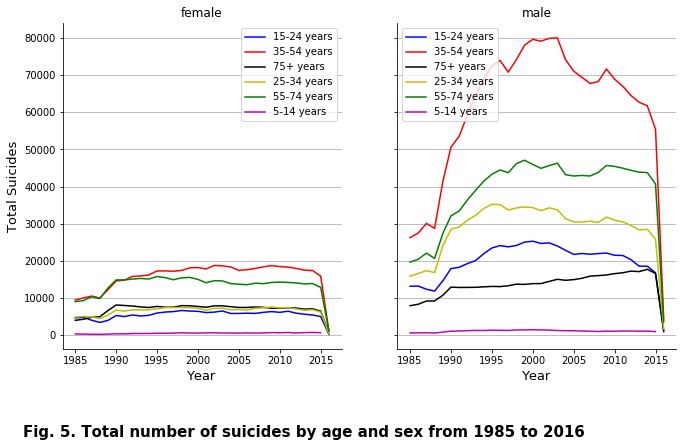

In [157]:
gender_age_data = data.groupby(["year", "sex", "age"]).suicides_no.sum().reset_index()

# Plotting
def plot(df, sex, age, ax, color):
    _df = df.query("(sex == @sex) & (age == @age)")
    _df.plot(
        kind = "line", x = "year", y = "suicides_no", ax = ax, color = color
)
    return ax
fig, ax = plt.subplots(1, 2, figsize=(11, 6), sharey=True)

# Naming the legends
labels = ["15-24 years", "35-54 years", "75+ years", "25-34 years", "55-74 years", "5-14 years"]

for (i, sex) in enumerate(gender_age_data.sex.unique()):
    plot(gender_age_data, sex,"15-24 years", ax[i], "b")
    plot(gender_age_data, sex,"35-54 years", ax[i], "r")
    plot(gender_age_data, sex,"75+ years", ax[i], "k")
    plot(gender_age_data, sex,"25-34 years", ax[i], "y")
    plot(gender_age_data, sex,"55-74 years", ax[i], "g")
    plot(gender_age_data, sex,"5-14 years", ax[i], "m")
    ax[i].set_title(str(sex))
    ax[i].legend(labels = labels)
    

for (i, _ax) in enumerate(ax):
    
    # setting axis labels
    _ax.set_xlabel("Year", size = 13)
    _ax.set_ylabel("Total Suicides", size = 13)
    
    _ax.spines['right'].set_visible(False)
    _ax.spines['top'].set_visible(False)
    
    _ax.yaxis.grid(True)
    

plt.suptitle("Fig. 5. Total number of suicides by age and sex from 1985 to 2016", x = 0.43, 
             y = -0.05, fontsize=15, fontweight = "bold")
plt.show()

#### Suicide Rates and Year for Different Countries

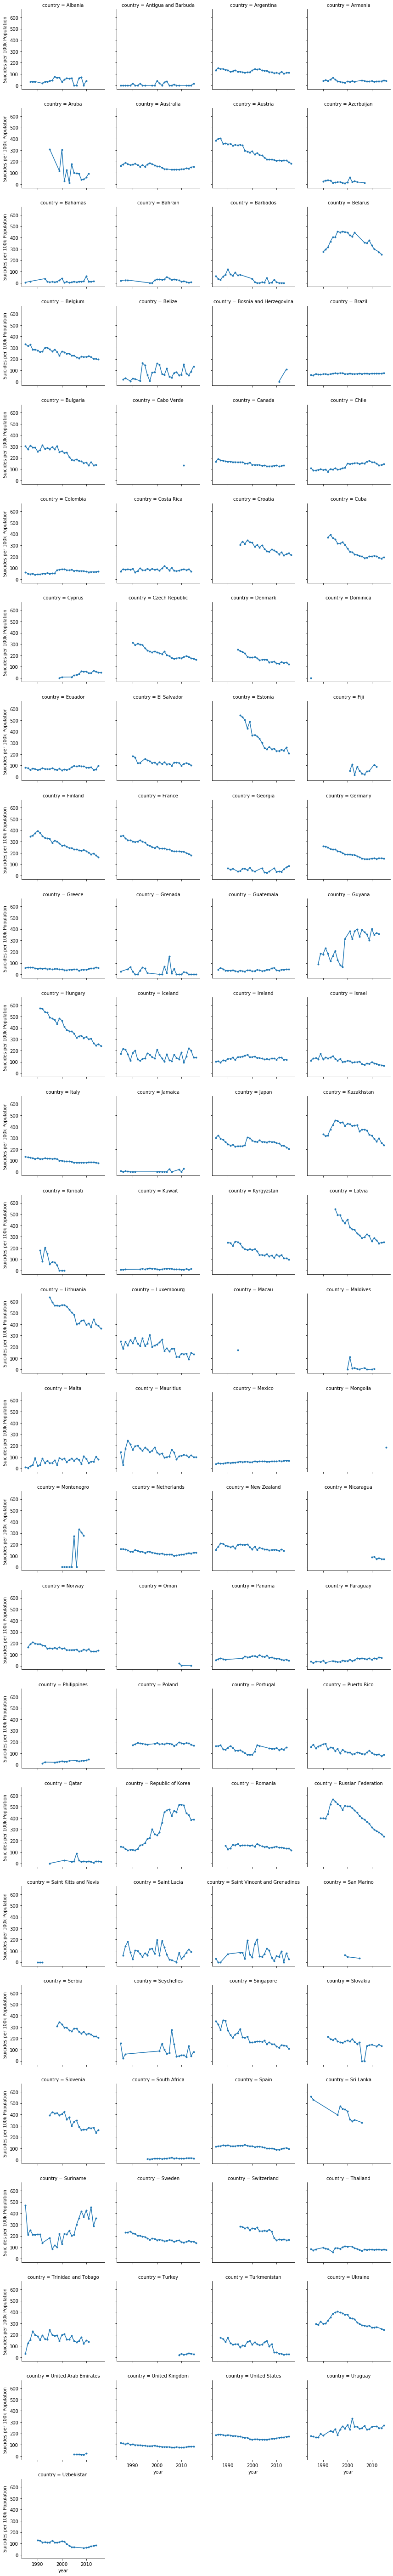

In [158]:
country_year_data = data.groupby(['country', 'year'], sort = True).sum()

country_year_data_suicides = country_year_data[["suicides_per_100k_pop"]].reset_index()
country_year_data_suicides.columns = ["country", "year", "Suicides per 100k Population"]

# Plotting
country_year_graph = sns.FacetGrid(country_year_data_suicides, col = "country", col_wrap = 4, sharey = True)
country_year_graph.map(plt.plot, "year", "Suicides per 100k Population", marker = ".")
plt.show()

#### World Map of Total Suicide Rates

In [160]:
country_data = data.groupby("country").sum()
country_data_suicides = country_data[["suicides_per_100k_pop"]].reset_index()
country_data_suicides = country_data_suicides.sort_values("suicides_per_100k_pop", ascending = False)
country_data_suicides.head()

,country,suicides_per_100k_pop
75,Russian Federation,11305.13
52,Lithuania,10588.88
40,Hungary,10156.07
47,Kazakhstan,9519.52
73,Republic of Korea,9350.45


In [161]:
# Finding the list of countries that are not in the world dataset

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

data_country = list(data.country.unique())
world_country = list(world.name.unique())

list(set(data_country)-set(world_country)) 

['Macau',
 'Antigua and Barbuda',
 'Republic of Korea',
 'Maldives',
 'Bosnia and Herzegovina',
 'Seychelles',
 'Malta',
 'Saint Vincent and Grenadines',
 'Czech Republic',
 'Mauritius',
 'Singapore',
 'Saint Lucia',
 'Aruba',
 'Cabo Verde',
 'United States',
 'San Marino',
 'Barbados',
 'Bahrain',
 'Grenada',
 'Kiribati',
 'Dominica',
 'Russian Federation',
 'Saint Kitts and Nevis']

In [162]:
# Comparing the countries in the world dataset and the countries in the data, 
# we see that some countries have different names in the world dataset. 
# So, I will change the names of some countries in the dataset.
# The map below does not include all the countries in the dataset.

country_data_suicides.loc[country_data_suicides.country == "Bosnia and Herzegovina", "country"] = "Bosnia and Herz."
country_data_suicides.loc[country_data_suicides.country == "Russian Federation", "country"] = "Russia"
country_data_suicides.loc[country_data_suicides.country == "United States", "country"] = "United States of America"
country_data_suicides.loc[country_data_suicides.country == "Dominica", "country"] = "Dominican Rep."
country_data_suicides.loc[country_data_suicides.country == "Czech Republic", "country"] = "Czechia"
country_data_suicides.loc[country_data_suicides.country == "Republic of Korea", "country"] = "South Korea"


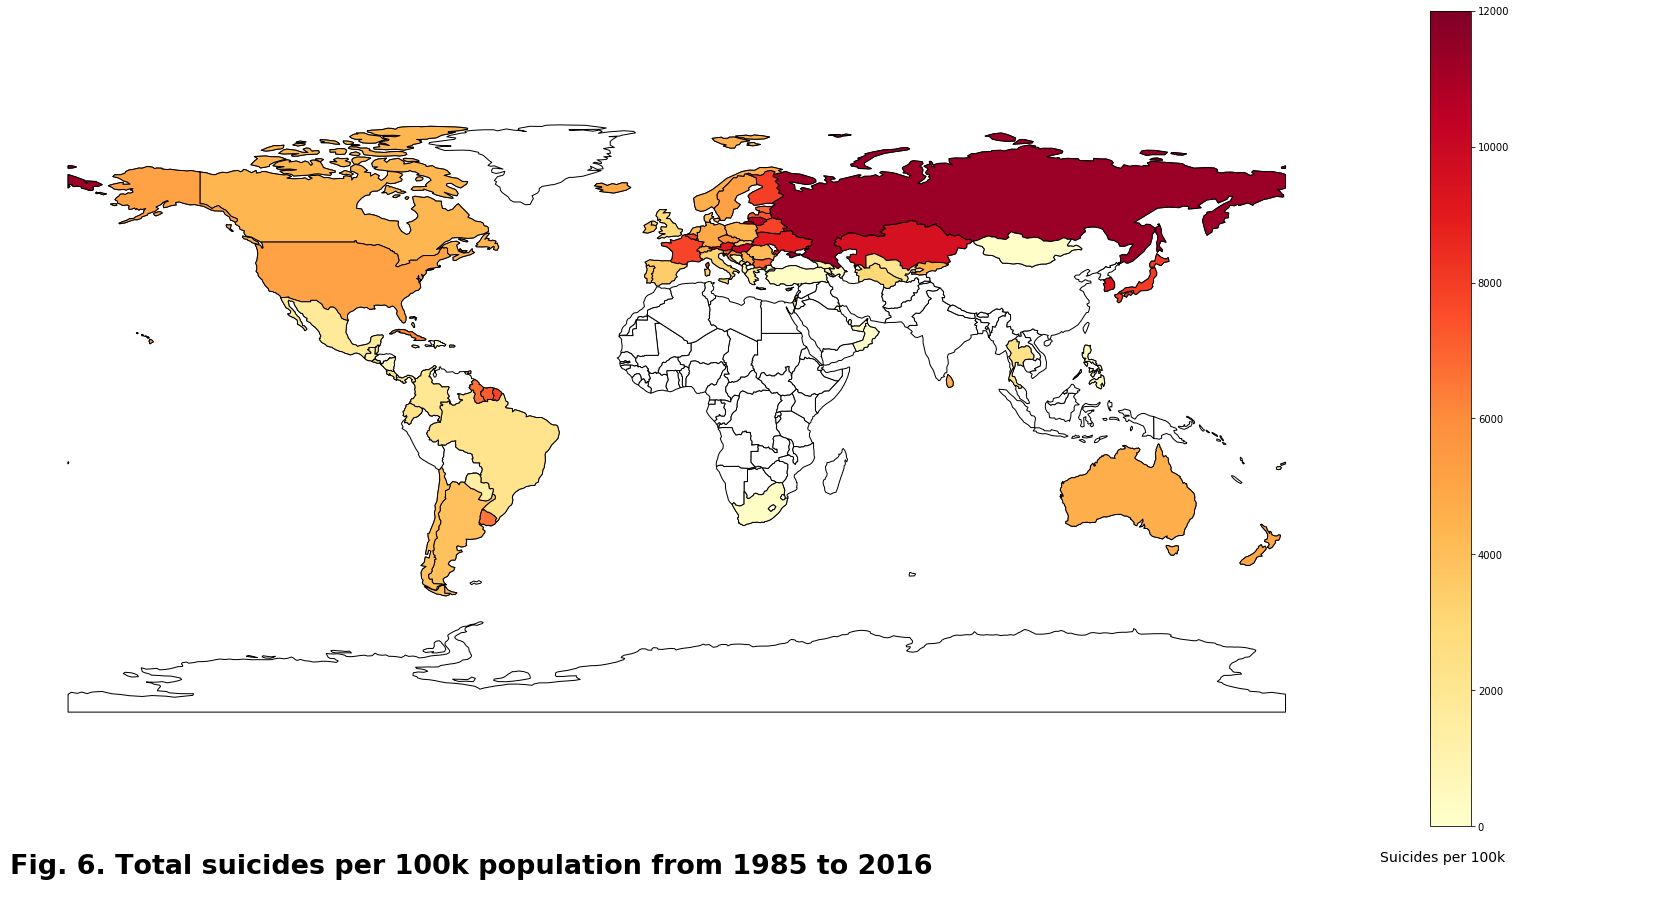

In [163]:
world_data = world.merge(country_data_suicides, left_on = "name", right_on = "country", how = "inner")

fig, ax = plt.subplots(figsize=(30,15))

# Plot the world
world.plot(ax=ax, edgecolor='black', color = "white")

world_data.plot(ax = ax, edgecolor = "black", column = "suicides_per_100k_pop", 
           legend = True, cmap = "YlOrRd", vmin = 0, vmax = 12000)

# turning off the axes
plt.axis("off")

# Adding text below the color bar
ax.annotate('Suicides per 100k',xy=(0.83, 0.055),  xycoords='figure fraction', size = 14)

plt.suptitle("Fig. 6. Total suicides per 100k population from 1985 to 2016", x = 0.34, y = 0.1, 
             fontsize=27, fontweight = "bold")
plt.show()

#### GDP per Capita and Suicide Rates 

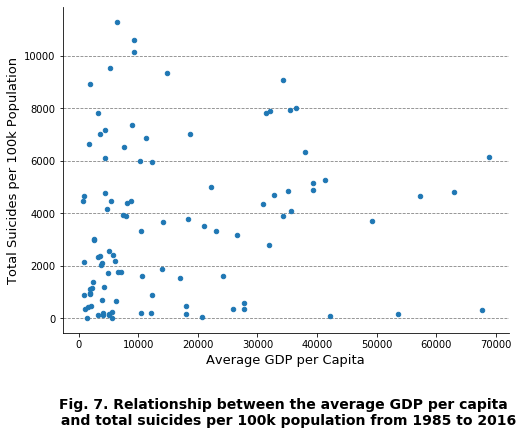

In [165]:
avg_gdp_data = data.groupby("country").agg({"suicides_no": "sum",
                                  "suicides_per_100k_pop": "sum",         
                                  "gdp_per_capita": "mean",
                                  "gdp_for_year": "mean"}).reset_index()

# Plotting
plt.rcParams["figure.figsize"] = [8, 6]
avg_gdp_graph = avg_gdp_data.plot(x = "gdp_per_capita", y = "suicides_per_100k_pop", kind = "scatter")

avg_gdp_graph.set_xlabel("Average GDP per Capita", size = 13)
avg_gdp_graph.set_ylabel("Total Suicides per 100k Population", size = 13)
avg_gdp_graph.set_title("Fig. 7. Relationship between the average GDP per capita \n and total suicides per 100k population from 1985 to 2016", 
                        size = 14,
                        x = 0.5, y = -0.3,
                        fontweight = "bold")

avg_gdp_graph.spines["right"].set_visible(False)
avg_gdp_graph.spines["top"].set_visible(False)

avg_gdp_graph.set_axisbelow(True)
avg_gdp_graph.yaxis.grid(color = "gray", linestyle = "dashed")


#### Comparison of the Average GDP per Year and Total Suicide Rates

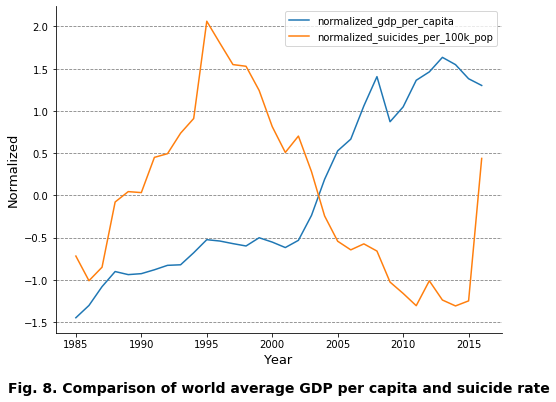

In [166]:
gdp_suicides_data= data.pivot_table(["suicides_per_100k_pop", "gdp_per_capita"],
                      index = "year", aggfunc = "mean")

# Standardization 
normalized = (gdp_suicides_data - gdp_suicides_data.mean())/ gdp_suicides_data.std()
normalized.columns = ["normalized_gdp_per_capita", "normalized_suicides_per_100k_pop"]

# Plotting
plt.rcParams["figure.figsize"] = [8, 6]
ax = normalized.plot()

ax.set_xlabel("Year", size = 13)
ax.set_ylabel("Normalized", size = 13)
ax.set_title("Fig. 8. Comparison of world average GDP per capita and suicide rate", 
                        size = 14,
                        x = 0.5, y = -0.2,
                        fontweight = "bold")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_axisbelow(True)
ax.yaxis.grid(color = "gray", linestyle = "dashed")

#### Total Suicides by Generation 

In [265]:
# Checking to see if the generations are balanced in terms of number

print("Number of observations for each generation")
count = data['generation'].value_counts()
count

Number of observations for each generation


Generation X       6408
Silent             6364
Millenials         5844
Boomers            4990
G.I. Generation    2744
Generation Z       1470
Name: generation, dtype: int64

Therefore, the number of observations is not balanced across the generations, and generation Z and G.I generation have the lowest number of observations. This could explain their low total suicide rates as graphed below.

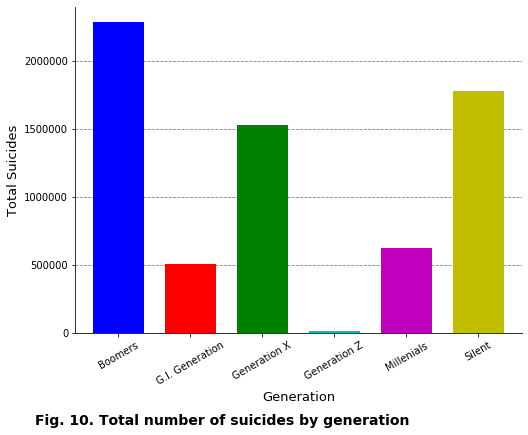

In [168]:
gen_table = data.pivot_table('suicides_no', index='generation', aggfunc='sum')
gen_table.reset_index(level = 0, inplace = True)

# Plotting
plt.rcParams["figure.figsize"] = [8, 6]

colors = ["b", "r", "g", "c", "m", "y"]
gen_graph = gen_table.plot(x = "generation", y = "suicides_no", kind = "bar", 
                           width = 0.7, color = colors)

plt.xlabel("Generation", size = 13)
plt.ylabel("Total Suicides", size = 13)
plt.title("Fig. 10. Total number of suicides by generation", 
          x = 0.33, y = -0.3,
          size = 14, fontweight = "bold")
plt.xticks(rotation = 30)

gen_graph.spines["right"].set_visible(False)
gen_graph.spines["top"].set_visible(False)

gen_graph.get_legend().remove()

gen_graph.set_axisbelow(True)
gen_graph.yaxis.grid(color = "gray", linestyle = "dashed")

#### Total Suicides by Generation and Age

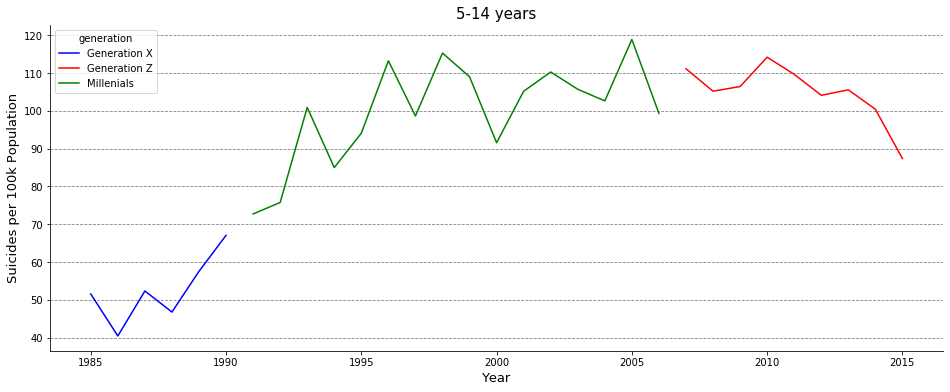

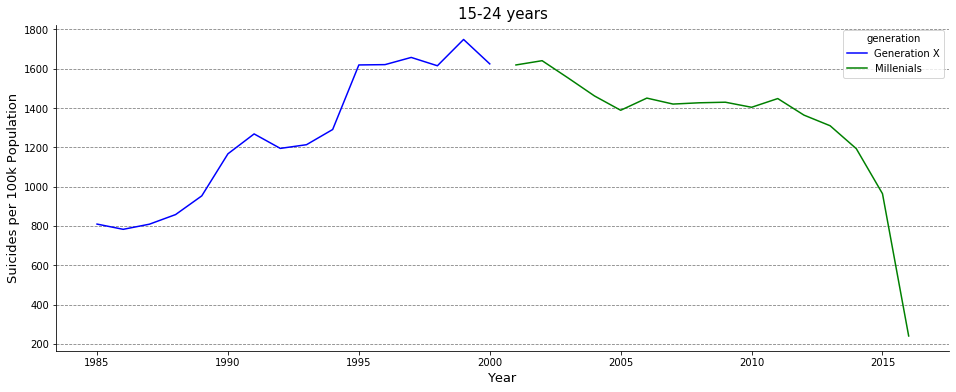

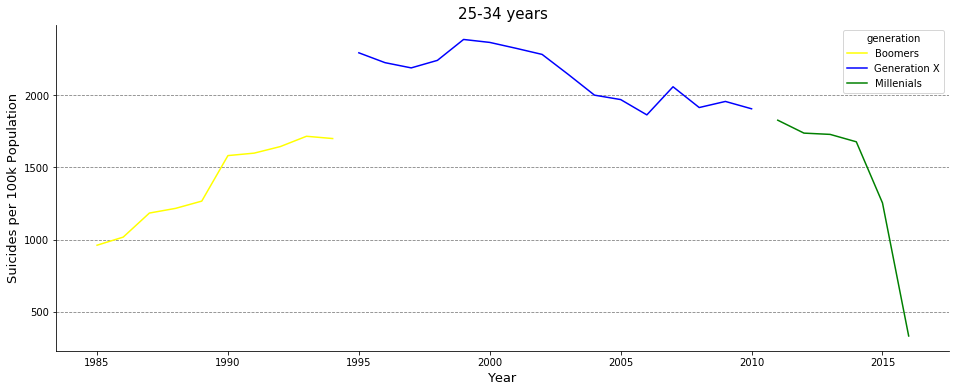

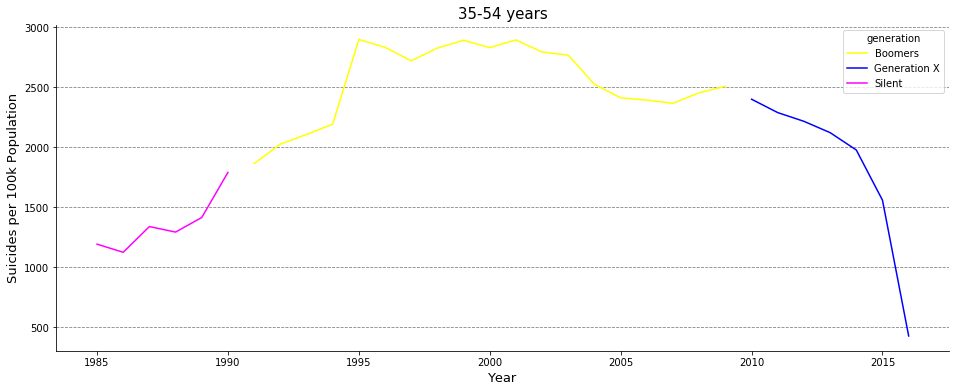

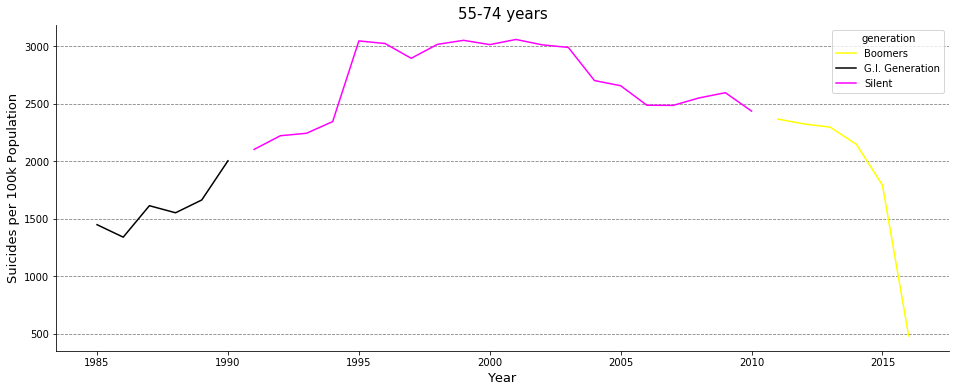

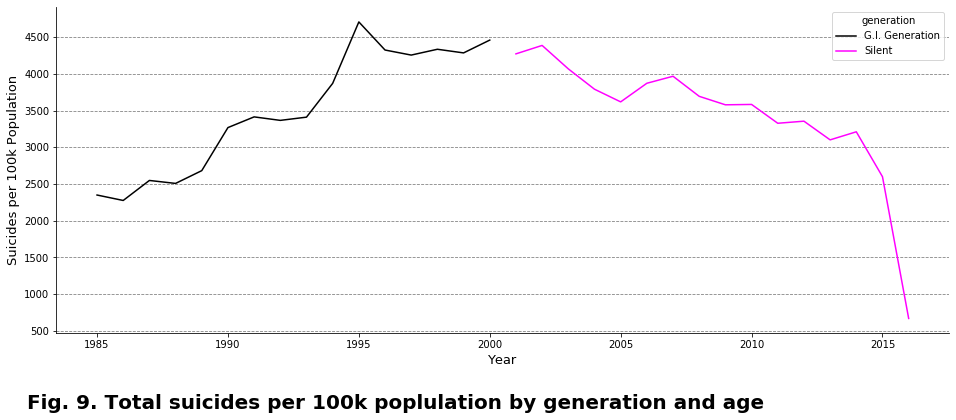

In [169]:
generation_data = data.groupby(["year", "age", "generation"]).sum()
generation_data = generation_data[["suicides_per_100k_pop"]].reset_index()

# Plotting
plt.rcParams["figure.figsize"] = [16, 6]

first = generation_data[generation_data.age == "5-14 years"]
first1 = first.pivot_table(index = "year", columns = "generation", values = "suicides_per_100k_pop")

second = generation_data[generation_data.age == "15-24 years"]
second2 = second.pivot_table(index = "year", columns = "generation", values = "suicides_per_100k_pop")

third = generation_data[generation_data.age == "25-34 years"]
third3 = third.pivot_table(index = "year", columns = "generation", values = "suicides_per_100k_pop")

fourth = generation_data[generation_data.age == "35-54 years"]
fourth4 = fourth.pivot_table(index = "year", columns = "generation", values = "suicides_per_100k_pop")

fifth = generation_data[generation_data.age == "55-74 years"]
fifth5 = fifth.pivot_table(index = "year", columns = "generation", values = "suicides_per_100k_pop")

sixth= generation_data[generation_data.age == "75+ years"]
sixth6 = sixth.pivot_table(index = "year", columns = "generation", values = "suicides_per_100k_pop") 

a = first1.plot(color = ["blue", "red", "green"])
b = second2.plot(color = ["blue", "green"])
c = third3.plot(color = ["yellow", "blue", "green"])
d = fourth4.plot(color = ["yellow", "blue", "magenta"])
e = fifth5.plot(color = ["yellow", "black", "magenta"])
f = sixth6.plot(color = ["black", "magenta"])

gen_list = [a, b,c, d, e, f]

for graph in gen_list:
    
    graph.set_xlabel("Year", size = 13)
    graph.set_ylabel("Suicides per 100k Population", size = 13)
    
    graph.spines['right'].set_visible(False)
    graph.spines['top'].set_visible(False)
    
    graph.set_axisbelow(True)
    graph.yaxis.grid(color = "gray", linestyle = "dashed")
    
    # graph titles
    if graph == a:
        graph.set_title('5-14 years', size = 15)
    if graph == b:
        graph.set_title('15-24 years', size = 15)
    if graph == c:
        graph.set_title('25-34 years', size = 15)
    if graph == d:
        graph.set_title('35-54 years', size = 15)
    if graph == e:
        graph.set_title('55-74 years', size = 15)
    if graph == f:
        graph.set_title('75+ years', size = 15)

f.set_title("Fig. 9. Total suicides per 100k poplulation by generation and age"
                               , x = 0.38, y = -0.25, 
                               size = 20, fontweight = "bold")
plt.show()

#### Population and Suicide by Risk

Text(0.38, -0.25, 'Fig. 10. Visualization of the target variable')

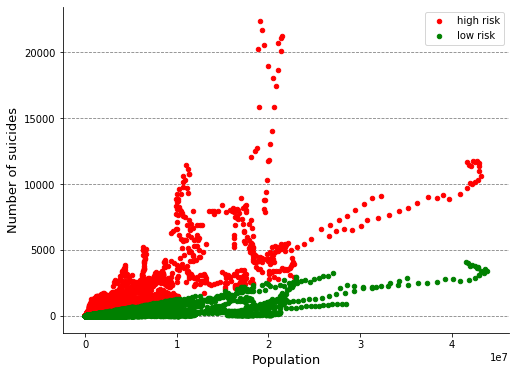

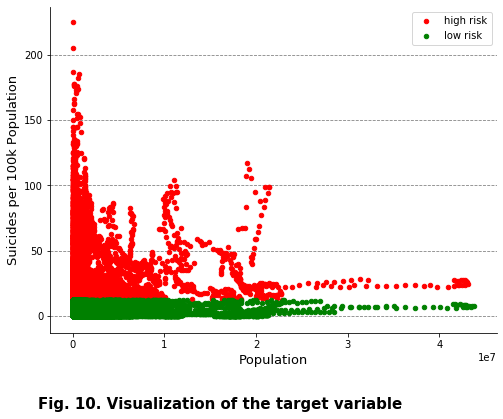

In [171]:
# Plotting
plt.rcParams["figure.figsize"] = [8, 6]

high_risk = data[data.risk == 1]
low_risk = data[data.risk == 0]

# Population and suicide number
plot_high = high_risk.plot(kind = "scatter",  x = "population", y = "suicides_no", 
                           color = "Red", label = "high risk")
plot_low = low_risk.plot(kind = "scatter", x = "population", y = "suicides_no", 
                         color = "Green", label = "low risk", ax = plot_high)

plot_high.set_xlabel("Population", size = 13)
plot_high.set_ylabel("Number of suicides", size = 13)


# population and suicide rate
plot_high2 = high_risk.plot(kind = "scatter",  x = "population", y = "suicides_per_100k_pop", 
                            color = "Red", label = "high risk")
plot_low2 = low_risk.plot(kind = "scatter", x = "population", y = "suicides_per_100k_pop", 
                          color = "Green", label = "low risk", ax = plot_high2)

plot_high2.set_xlabel("Population", size = 13)
plot_high2.set_ylabel("Suicides per 100k Population", size = 13)


graphs = [plot_high, plot_high2]
for graph in graphs:
    
    graph.spines["right"].set_visible(False)
    graph.spines["top"].set_visible(False)

    graph.set_axisbelow(True)
    graph.yaxis.grid(color = "gray", linestyle = "dashed")

plot_high2.set_title("Fig. 10. Visualization of the target variable"
                               , x = 0.38, y = -0.25, 
                               size = 15, fontweight = "bold")


#### Number of Observations in Each Class

In [172]:
print("Number of observations in each class:")
count = data['risk'].value_counts()
count

Number of observations in each class:


0    19061
1     8759
Name: risk, dtype: int64

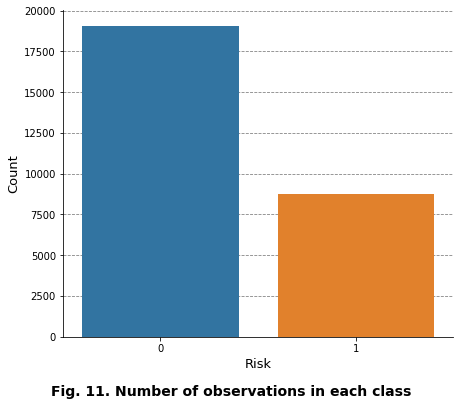

In [177]:
plt.rcParams["figure.figsize"] = [7, 6]
count_plot = sns.countplot(x = "risk", data = data)

plt.xlabel("Risk", size = 13)
plt.ylabel("Count", size = 13)
plt.title("Fig. 11. Number of observations in each class", 
          x = 0.43, y = -0.2,
          size = 14, fontweight = "bold")

count_plot.spines["right"].set_visible(False)
count_plot.spines["top"].set_visible(False)

count_plot.set_axisbelow(True)
count_plot.yaxis.grid(color = "gray", linestyle = "dashed")

plt.show()

We observe that the data is not balanced across the classes, and therefore I will upscale the data to make the data balanced across the classes.

In [204]:
# Upscaling

# Separating the majority and minority classes
majority = data[data.risk == 0]
minority = data[data.risk == 1]

upsampled = resample(minority, replace=True,     
                                n_samples=19061, 
                                random_state=123)
df= pd.concat([majority, upsampled])

print("Number of observations in each class after upscaling:")
df.risk.value_counts()

Number of observations in each class after upscaling:


1    19061
0    19061
Name: risk, dtype: int64

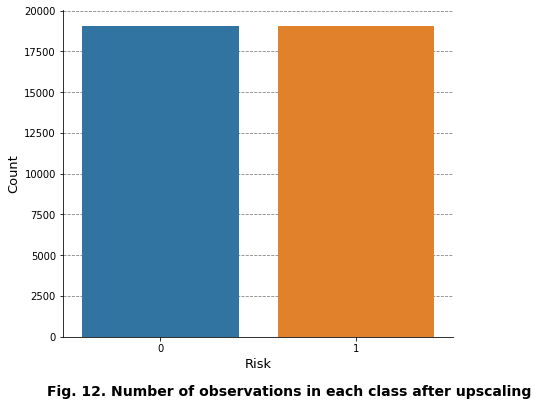

In [205]:
# Plotting

plt.rcParams["figure.figsize"] = [7, 6]
count_plot2 = sns.countplot(x = "risk", data = df)

plt.xlabel("Risk", size = 13)
plt.ylabel("Count", size = 13)
plt.title("Fig. 12. Number of observations in each class after upscaling", 
          x = 0.58, y = -0.2,
          size = 14, fontweight = "bold")

count_plot2.spines["right"].set_visible(False)
count_plot2.spines["top"].set_visible(False)

count_plot2.set_axisbelow(True)
count_plot2.yaxis.grid(color = "gray", linestyle = "dashed")


#### Getting the Data Ready for Classification

In [179]:
# Data cleaning for classification

# Converting categorical variables to numerical
le = LabelEncoder()
df["country"] = le.fit_transform(df["country"])

df["sex"] = le.fit_transform(df["sex"])

df.generation.replace(["G.I. Generation", "Silent", "Boomers", "Generation X", "Millenials", "Generation Z"],
                     ["0", "1", "2", "3", "4", "5"], inplace = True)

# Changing the type of the "generation" column
df["generation"] = df["generation"].astype(int)

# Replacing the age intervals with their means
df.age.replace(["5-14 years", "15-24 years", "25-34 years", 
                "35-54 years", "55-74 years", "75+ years"],
              [np.array([5,14]).mean(), np.array([15,24]).mean(), np.array([25,34]).mean(), 
               np.array([35,54]).mean(), np.array([55,74]).mean(), np.array([75]).mean()],
               inplace = True
              )

## Classification

For the classification analysis, I will be using models such as logistic regression, neural networks, decision tree and random forest. After, I will try to find the best model by comparing the performance of the models.

In [185]:
# Seperating the target variable and predictors
X = df.drop(["risk", "country-year", "suicides_per_100k_pop"], axis = 1)
y = df["risk"]

# Scaling X
scaled_X = (X-X.mean())/ X.std()

# Training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(scaled_X, y, test_size=0.25, random_state = 40)

# Number of rows and columns
print("Number of observations and columns")
print("Training Set:")
print(X_train.shape)
print(y_train.shape)
print("Testing Set:")
print(X_test.shape)
print(y_test.shape)


Number of observations and columns
Training Set:
(28591, 9)
(28591,)
Testing Set:
(9531, 9)
(9531,)


### Logistic Regression

In [53]:
logistic_model = linear_model.LogisticRegression(solver = "lbfgs")
logistic_model.fit(X_train, y_train)

lr_pred = logistic_model.predict(X_test)

# Training and testing accuracy
lr_train_acc = logistic_model.score(X_train, y_train)
lr_test_acc = logistic_model.score(X_test, y_test)

print("\033[1m Logistic regression accuracies: \033[0m")
print(f"Training accuracy: {lr_train_acc}")
print(f"Testing accuracy: {lr_test_acc}")
print("")

lm_con_mat = metrics.confusion_matrix(y_test, lr_pred)
print("\033[1m Confusion matrix for logistic regression: \033[0m")
print(lm_con_mat)
print("")

lr_report = metrics.classification_report(y_test, lr_pred)
print("\033[1m Logistic regression classification report: \033[0m")
print(lr_report)

 Logistic regression accuracies: 
Training accuracy: 0.9124899443880942
Testing accuracy: 0.9173224215717134

 Confusion matrix for logistic regression: 
[[4376  369]
 [ 419 4367]]

 Logistic regression classification report: 
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      4745
           1       0.92      0.91      0.92      4786

    accuracy                           0.92      9531
   macro avg       0.92      0.92      0.92      9531
weighted avg       0.92      0.92      0.92      9531



### Neural Networks (MLP Classifier)

In [220]:
nn_model = MLPClassifier(solver = "lbfgs", random_state = 40, max_iter = 3000)
nn_model.fit(X_train, y_train)

nn_pred = nn_model.predict(X_test)

nn_train_acc = nn_model.score(X_train, y_train)
nn_test_acc = nn_model.score(X_test, y_test)

print("\033[1m MLP classifier accuracies: \033[0m")
print(f"Training accuracy: {nn_train_acc}")
print(f"Testing accuracy: {nn_test_acc}")
print("")

nn_con_mat = metrics.confusion_matrix(y_test, nn_pred)
print("\033[1m Confusion matrix for MLP classifier: \033[0m")
print(nn_con_mat)
print("")

nn_report = metrics.classification_report(y_test, nn_pred)
print("\033[1m MLP classifier report: \033[0m")
print(nn_report)


 MLP classifier accuracies: 
Training accuracy: 1.0
Testing accuracy: 0.996432693316546

 Confusion matrix for MLP classifier: 
[[4718   27]
 [   7 4779]]

 MLP classifier report: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4745
           1       0.99      1.00      1.00      4786

    accuracy                           1.00      9531
   macro avg       1.00      1.00      1.00      9531
weighted avg       1.00      1.00      1.00      9531



### Decision Tree

In [55]:
dt_model = DecisionTreeClassifier(max_depth = 25, max_leaf_nodes = 33)
dt_model.fit(X_train, y_train)

dt_pred = dt_model.predict(X_test)

dt_train_acc = dt_model.score(X_train, y_train)
dt_test_acc = dt_model.score(X_test, y_test)

print("\033[1m Decision tree accuracies: \033[0m")
print(f"Training accuracy: {dt_train_acc}")
print(f"Testing accuracy: {dt_test_acc}")
print("")

dt_con_mat = metrics.confusion_matrix(y_test, dt_pred)
print("\033[1m Confusion matrix for decision tree: \033[0m")
print(dt_con_mat)
print("")

dt_report = metrics.classification_report(y_test, dt_pred)
print("\033[1m Decision tree report: \033[0m")
print(dt_report)


 Decision tree accuracies: 
Training accuracy: 0.939666328564933
Testing accuracy: 0.9314867275207218

 Confusion matrix for decision tree: 
[[4245  500]
 [ 153 4633]]

 Decision tree report: 
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      4745
           1       0.90      0.97      0.93      4786

    accuracy                           0.93      9531
   macro avg       0.93      0.93      0.93      9531
weighted avg       0.93      0.93      0.93      9531



### Random Forest

In [56]:
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state = 40)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

rf_train_acc = rf_model.score(X_train, y_train)
rf_test_acc = rf_model.score(X_test, y_test)

print("\033[1m Random forest accuracies: \033[0m")
print(f"Training accuracy: {rf_train_acc}")
print(f"Testing accuracy: {rf_test_acc}")
print("")

rf_con_mat = metrics.confusion_matrix(y_test, rf_pred)
print("\033[1m Confusion matrix for random forest: \033[0m")
print(rf_con_mat)
print("")

rf_report = metrics.classification_report(y_test, rf_pred)
print("\033[1m Random forest report: \033[0m")
print(rf_report)

 Random forest accuracies: 
Training accuracy: 0.9951733062851946
Testing accuracy: 0.9857307732661841

 Confusion matrix for random forest: 
[[4636  109]
 [  27 4759]]

 Random forest report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4745
           1       0.98      0.99      0.99      4786

    accuracy                           0.99      9531
   macro avg       0.99      0.99      0.99      9531
weighted avg       0.99      0.99      0.99      9531



According to the results above, the neural networks (MLP classifier) has pretty impressive results and outperforms the other models in terms of accuracy, precision, recall, etc. The second best is the random forest model which seems to have pretty good results as well. The third best is the decision tree model, and the model with the worst performance is the logistic regression model.

Since the best model is the MLP classifier, I wondered if I could improve the performance by tuning the classifier. Therefore, I will adjust the hyper-parameters of the MLP classifier in an attempt of getting a more perfect performance.

### MLP Classifier After Being Tuned

In [188]:
mlp = MLPClassifier(max_iter=100)

parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (50,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp, parameters, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

# Best parameters
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


In [221]:
nn_model2 = MLPClassifier(solver = "lbfgs", activation = "tanh", alpha = 0.0001, 
                          hidden_layer_sizes = (50,50,50), learning_rate = "adaptive", 
                          random_state = 40, max_iter = 3000)

nn_model2.fit(X_train, y_train)

nn_pred2 = nn_model2.predict(X_test)

nn_train_acc2 = nn_model2.score(X_train, y_train)
nn_test_acc2 = nn_model2.score(X_test, y_test)


print("\033[1m MLP classifier after being tuned accuracies: \033[0m")
print(f"Training accuracy: {nn_train_acc2}")
print(f"Testing accuracy: {nn_test_acc2}")
print("")

nn_con_mat2 = metrics.confusion_matrix(y_test, nn_pred2)
print("\033[1m Confusion matrix for MLP classifier after being tuned: \033[0m")
print(nn_con_mat2)
print("")

nn_report2 = metrics.classification_report(y_test, nn_pred2)
print("\033[1m MLP classifier report: \033[0m")
print(nn_report2)

 MLP classifier after being tuned accuracies: 
Training accuracy: 0.9997551677101185
Testing accuracy: 0.9980065050886581

 Confusion matrix for MLP classifier after being tuned: 
[[4728   17]
 [   2 4784]]

 MLP classifier report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4745
           1       1.00      1.00      1.00      4786

    accuracy                           1.00      9531
   macro avg       1.00      1.00      1.00      9531
weighted avg       1.00      1.00      1.00      9531



After tuning the MLP Classifier, we observe that the training accuracy decreases by a very small amount, and the testing accuracy increases by a very small amount. From the confusion matrix, we observe that before tuning, the number of incorrect predictions is 34, and after tuning this number decreases to 19. Furthermore, all the columns in the classifier report have perfect scores. Therefore, overall, the MLP classifier after being tuned outperforms every other model above.

## ROC Curves and AUC Scores

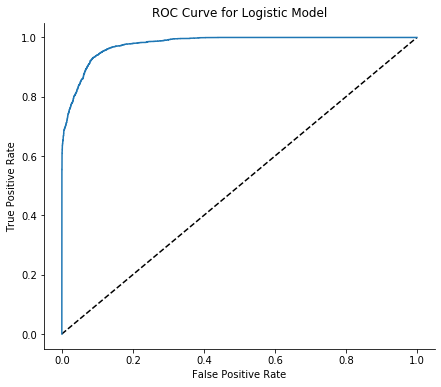

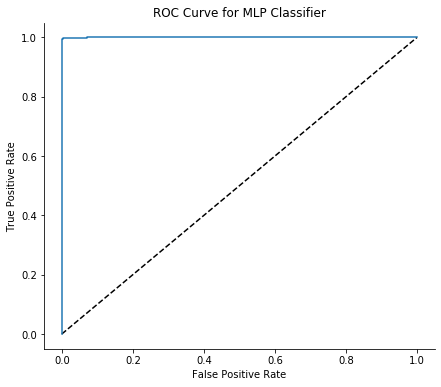

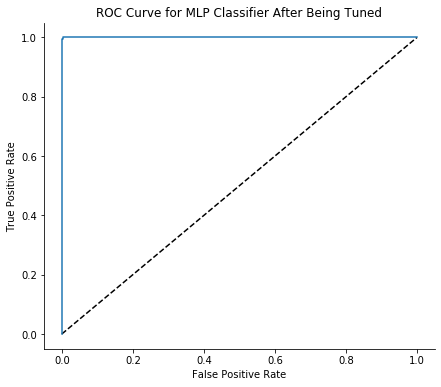

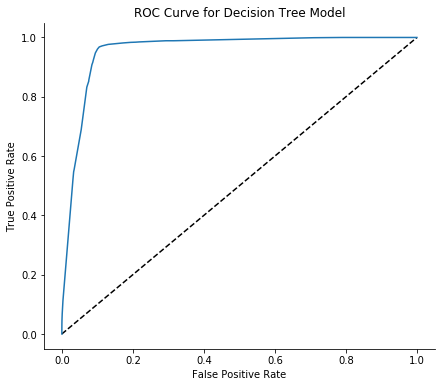

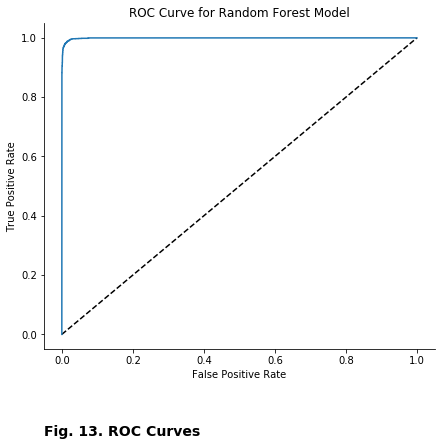

In [211]:
# ROC curves
def ROC(model, X, y):
    
    probs_predict = model.predict_proba(X_test)
    probs_predict1 = probs_predict[:, 1]
    false, true, _ = metrics.roc_curve(y_test, probs_predict1)
    
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], "k--")
    ax.plot(false, true)
    
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    if model == logistic_model:
        ax.set_title("ROC Curve for Logistic Model")
    if model == nn_model:
        ax.set_title("ROC Curve for MLP Classifier")
    if model == nn_model2:
        ax.set_title("ROC Curve for MLP Classifier After Being Tuned")
    if model == dt_model:
        ax.set_title("ROC Curve for Decision Tree Model")
    if model == rf_model:
        ax.set_title("ROC Curve for Random Forest Model")
        
    if model == rf_model:
        plt.suptitle("Fig. 13. ROC Curves", x = 0.28, 
             y = -0.05, fontsize=14, fontweight = "bold")
    
lr_roc = ROC(logistic_model, X_test, y_test)
nn_roc = ROC(nn_model, X_test, y_test)
nn_roc = ROC(nn_model2, X_test, y_test)
dt_roc = ROC(dt_model, X_test, y_test)
rf_roc = ROC(rf_model, X_test, y_test)

In [255]:
# AUC Scores

predicted_prob1 = logistic_model.predict_proba(X_test)[:, 1]
auc1 = metrics.roc_auc_score(y_test, predicted_prob1)
print(f"logistic regression: AUC is {auc1:.5f}")

predicted_prob2 = nn_model.predict_proba(X_test)[:, 1]
auc2 = metrics.roc_auc_score(y_test, predicted_prob2)
print(f"MLP Classifier: AUC is {auc2:.5f}")

predicted_prob3 = nn_model2.predict_proba(X_test)[:, 1]
auc3 = metrics.roc_auc_score(y_test, predicted_prob3)
print(f"MLP Classifier after tuning: AUC is {auc3:.5f}")

predicted_prob4 = dt_model.predict_proba(X_test)[:, 1]
auc4 = metrics.roc_auc_score(y_test, predicted_prob4)
print(f"Decision tree: AUC is {auc4:.5f}")

predicted_prob5 = rf_model.predict_proba(X_test)[:, 1]
auc5 = metrics.roc_auc_score(y_test, predicted_prob5)
print(f"Random forest: AUC is {auc5:.5f}")


logistic regression: AUC is 0.97781
MLP Classifier: AUC is 0.99992
MLP Classifier after tuning: AUC is 0.99998
Decision tree: AUC is 0.95600
Random forest: AUC is 0.99930


We observe that the MLP classifier after being tuned has the highest AUC, and thus it is indeed the best model in distinguishing between high risk and low risk groups. 

## Feature Importance

Here, I will look at what features are the most important for each of the models above.

### Logistic Regression

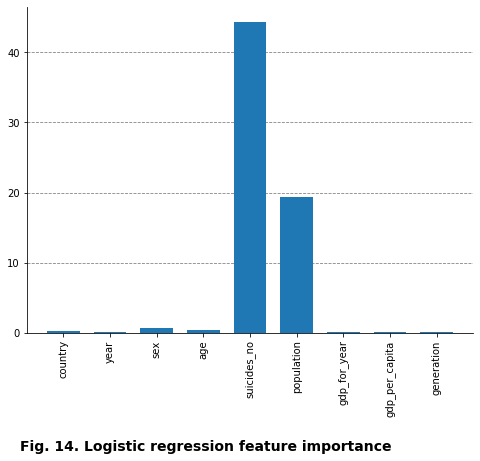

In [213]:
# The feature importance is based on the magnitude of the coefficients of the features.

# Getting the features
coefs = logistic_model.coef_[0]
abs_coefs = np.abs(coefs)

# Plotting
fig, ax = plt.subplots(figsize = (8,6))

lr_importance = plt.bar([x for x in range (len(abs_coefs))], abs_coefs, width  = 0.7)
plt.xticks(np.arange(0, 9, 1))

labels = ['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'gdp_for_year', 'gdp_per_capita', 'generation']

ax.xaxis.set_ticklabels(labels, rotation = 90)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


ax.set_axisbelow(True)
ax.yaxis.grid(color = "gray", linestyle = "dashed")

ax.set_title("Fig. 14. Logistic regression feature importance"
                               , x = 0.4, y = -0.38, 
                               size = 14, fontweight = "bold")

plt.show()

### MLP Classifier 

In [214]:
# Using permutation feature importance

perm = PermutationImportance(nn_model, random_state = 40).fit(X_train, y_train)
weights = eli5.show_weights(perm, feature_names = X_test.columns.tolist())
weights

Weight,Feature
0.5098 ± 0.0058,suicides_no
0.3230 ± 0.0028,population
0.0279 ± 0.0010,generation
0.0236 ± 0.0008,age
0.0137 ± 0.0009,year
0.0123 ± 0.0009,gdp_per_capita
0.0121 ± 0.0013,country
0.0116 ± 0.0006,gdp_for_year
0.0077 ± 0.0005,sex


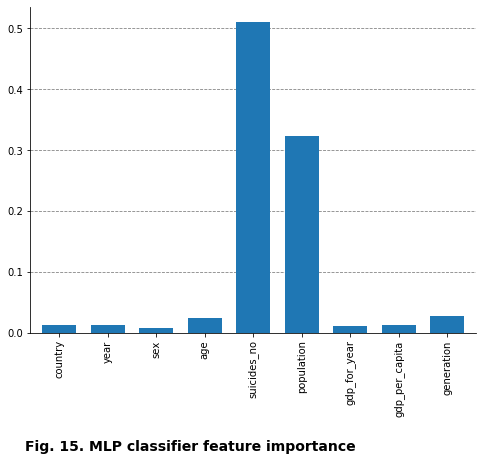

In [215]:
# Plotting

plt.rcParams["figure.figsize"] = [8, 6]

index = ['country', 'year', 'sex', 'age', 'suicides_no', 'population', 'gdp_for_year', 'gdp_per_capita', 'generation']
nn_imp_data = [0.0121, 0.0137, 0.0077, 0.0236, 0.5098, 0.323, 0.0116, 0.0123, 0.0279]
                
nn_feat = pd.Series(nn_imp_data, index = index)
nn_importance = nn_feat.plot(kind = "bar", width = 0.7)
nn_importance

nn_importance.spines["right"].set_visible(False)
nn_importance.spines["top"].set_visible(False)

nn_importance.set_axisbelow(True)
nn_importance.yaxis.grid(color = "gray", linestyle = "dashed")

nn_importance.set_title("Fig. 15. MLP classifier feature importance"
                               , x = 0.36, y = -0.38, 
                               size = 14, fontweight = "bold")

plt.show()

### MLP Classifier After Being Tuned

In [222]:
# Using permutation feature importance

perm2 = PermutationImportance(nn_model2, random_state = 40).fit(X_train, y_train)
weights2 = eli5.show_weights(perm2, feature_names = X_test.columns.tolist())
weights2

Weight,Feature
0.5134 ± 0.0061,suicides_no
0.3295 ± 0.0033,population
0.0145 ± 0.0006,gdp_for_year
0.0119 ± 0.0007,generation
0.0110 ± 0.0010,age
0.0053 ± 0.0007,gdp_per_capita
0.0033 ± 0.0004,year
0.0032 ± 0.0003,country
0.0016 ± 0.0002,sex


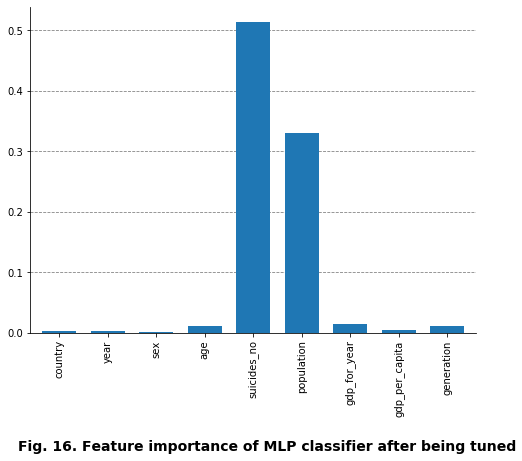

In [228]:
# Plotting

plt.rcParams["figure.figsize"] = [8, 6]

index = ['country', 'year', 'sex', 'age', 'suicides_no', 'population', 'gdp_for_year', 'gdp_per_capita', 'generation']
nn_imp_data2 = [0.0032, 0.0033, 0.0016, 0.011, 0.5134, 0.3295, 0.0145, 0.0053, 0.0119]
                
nn_feat2 = pd.Series(nn_imp_data2, index = index)
nn_importance2 = nn_feat2.plot(kind = "bar", width = 0.7)
nn_importance2

nn_importance2.spines["right"].set_visible(False)
nn_importance2.spines["top"].set_visible(False)

nn_importance2.set_axisbelow(True)
nn_importance2.yaxis.grid(color = "gray", linestyle = "dashed")

nn_importance2.set_title("Fig. 16. Feature importance of MLP classifier after being tuned",
                               x = 0.53, y = -0.38, 
                               size = 14, fontweight = "bold")

plt.show()

### Decision Tree

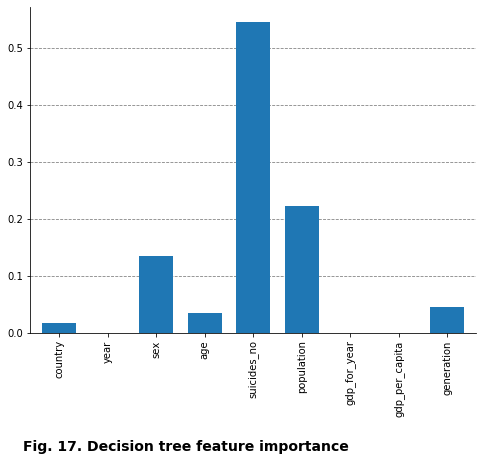

In [229]:
plt.rcParams["figure.figsize"] = [8, 6]
dt_feat = pd.Series(dt_model.feature_importances_, index = scaled_X.columns)
dt_importance = dt_feat.plot(kind = 'bar', width = 0.7)
dt_importance

dt_importance.spines["right"].set_visible(False)
dt_importance.spines["top"].set_visible(False)

dt_importance.set_axisbelow(True)
dt_importance.yaxis.grid(color = "gray", linestyle = "dashed")

dt_importance.set_title("Fig. 17. Decision tree feature importance"
                               , x = 0.35, y = -0.38, 
                               size = 14, fontweight = "bold")
plt.show()

### Random Forest

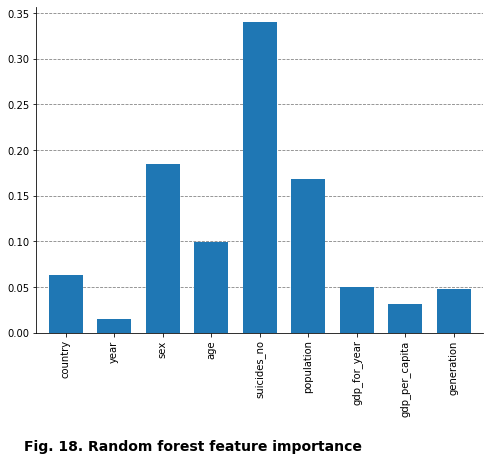

In [230]:
plt.rcParams["figure.figsize"] = [8, 6]
rf_feat = pd.Series(rf_model.feature_importances_, index = scaled_X.columns)
rf_importance = rf_feat.plot(kind = 'bar', width = 0.7)
rf_importance

rf_importance.spines["right"].set_visible(False)
rf_importance.spines["top"].set_visible(False)

rf_importance.set_axisbelow(True)
rf_importance.yaxis.grid(color = "gray", linestyle = "dashed")

rf_importance.set_title("Fig. 18. Random forest feature importance"
                               , x = 0.35, y = -0.38, 
                               size = 14, fontweight = "bold")

plt.show()

From the results above, we see that not every feature has the same importance in every models. For example, the MLP classifier deems features other than suicides_no and population as not very important. However, the random forest model deems those features as more important, and the weight is not solely on two features.

## Conclusion

After performing exploratory data analysis and classification analysis, I have found that the MLP classifier after being tuned is the best classifier for classifying and predicting groups at high risks of suicide. This classifier deems suicide numbers and population as the most important features for making predictions.